# Segmenting and Clustering Neighborhoods in Toronto
## PART 3 - CLUSTERING
I'm loading all the packages I need. After that, I'm importing the data I saved from part 1 and 2 (see the other notebook in this folder)

In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium
import requests 
df = pd.read_csv('complete_dataframe.csv')
df = df[["Postcode", "Borough", "Neighbourhood", "lat", "lng"]]
df.head()

,Postcode,Borough,Neighbourhood,lat,lng
0,M1B,Scarborough,"Rouge,Malvern",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.785730,-79.158750
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.765690,-79.175256
3,M1G,Scarborough,Woburn,43.768359,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440


Let's print a map with all the neighbourhood

In [4]:
map = folium.Map(location=[43.653908, -79.384293], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['lat'], df['lng'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

### Exploration with Foursquare
I'm going to Load data and do some exploration.
I will a a category extractor helper before:

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
CLIENT_ID = '???' # your Foursquare ID
CLIENT_SECRET = '???' # your Foursquare Secret
VERSION = '???' # Foursquare API version

In [36]:
from pandas.io.json import json_normalize
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

def getNearbyVenues(names, latitudes, longitudes, radius=650):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION, 
            lat, lng, radius, 100)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [38]:
venues = getNearbyVenues(names=df['Neighbourhood'], latitudes=df['lat'], longitudes=df['lng'])
venues.shape

(3136, 7)

In [41]:
venues.to_csv(r'toronto_venues.csv')
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))
venues.head()

There are 292 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.811525,-79.195517,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge,Malvern",43.811525,-79.195517,Moose Exhibit,43.816823,-79.193432,Zoo Exhibit
2,"Rouge,Malvern",43.811525,-79.195517,Grizzly Bear Exhibit,43.817031,-79.193458,Zoo Exhibit
3,"Rouge,Malvern",43.811525,-79.195517,St Jacob's Market,43.815640,-79.189783,Farmers Market
4,"Highland Creek,Rouge Hill,Port Union",43.785730,-79.158750,Royal Canadian Legion,43.782533,-79.163085,Bar


Let's analyze data...

In [42]:
# one hot encoding
df_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
df_onehot['Neighborhood'] = venues['Neighborhood'] 
df_onehot = df_onehot[[df_onehot.columns[-1]] + list(df_onehot.columns[:-1])]

df_onehot.head()

,Zoo Exhibit,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,Art Gallery,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waste Facility,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
grouped = df_onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,Zoo Exhibit,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waste Facility,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.0,0.00,0.00,0.0,0.00,0.030000,0.0,0.000000,0.0,...,0.00,0.010000,0.000000,0.000000,0.0,0.01,0.00,0.00,0.000000,0.000000
1,Agincourt,0.0,0.00,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.043478,0.0,0.00,0.00,0.00,0.000000,0.000000
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.00,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.00,0.000000,0.000000
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.00,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.00,0.000000,0.000000
4,"Alderwood,Long Branch",0.0,0.00,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.00,0.000000,0.000000
5,"Bathurst Manor,Downsview North,Wilson Heights",0.0,0.00,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.00,0.000000,0.000000
6,Bayview Village,0.0,0.00,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.00,0.000000,0.000000
7,"Bedford Park,Lawrence Manor East",0.0,0.00,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.00,0.000000,0.000000
8,Berczy Park,0.0,0.00,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.00,0.010000,0.000000,0.000000,0.0,0.00,0.00,0.00,0.000000,0.000000
9,"Birch Cliff,Cliffside West",0.0,0.00,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,...,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.00,0.000000,0.000000


Let's work on common values

In [188]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    columns.append('{}^ most common venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1^ most common venue,2^ most common venue,3^ most common venue,4^ most common venue,5^ most common venue,6^ most common venue,7^ most common venue,8^ most common venue,9^ most common venue,10^ most common venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Hotel,Restaurant,Bar,Gastropub,Steakhouse,Burger Joint,Bakery,American Restaurant
1,Agincourt,Shopping Mall,Chinese Restaurant,Hong Kong Restaurant,Sushi Restaurant,Supermarket,Breakfast Spot,Shanghai Restaurant,Sandwich Place,Coffee Shop,Bakery
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Sandwich Place,Sushi Restaurant,Pharmacy,Park,Farm,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Sandwich Place,Pizza Place,Pharmacy,Fast Food Restaurant,Beer Store,Hardware Store,Fried Chicken Joint,Park,Coffee Shop
4,"Alderwood,Long Branch",Coffee Shop,Sandwich Place,Pizza Place,Pharmacy,Pub,Gas Station,Gym,Yoga Studio,Eastern European Restaurant,Electronics Store


### Klustering moment
Let's create clusters.

First thing I'm going to find a good K

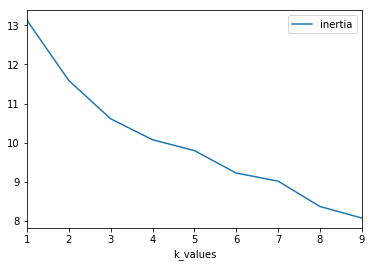

In [196]:
%matplotlib inline

clustering = grouped.drop('Neighborhood', 1)
keys = []
interias = []
for k in range (1, 10):
    kmeans_model = KMeans(n_clusters=k, random_state=0).fit(clustering)
    interia = kmeans_model.inertia_
    keys.append(k)
    interias.append(interia)
s = pd.DataFrame({'k_values': keys, 'inertia': interias})
s.plot.line(x = "k_values", y = "inertia")

The elbow suggest **k to be 5**.

Now let check some randomness is finding the starting center.
I will then choose the right kmeans looking at distribution

In [224]:
# add clustering labels
rs = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=5, random_state=i).fit(clustering)
    rs.append(kmeans)
    y = np.bincount(kmeans.labels_)
    print("{}: {} ({})".format(i, y, np.std(y)))

1: [83  1 15  1  1] (31.864714026647093)
2: [ 2 83 14  1  1] (31.783014331557666)
3: [79  3 17  1  1] (30.002666548158683)
4: [ 1 83  1  1 15] (31.864714026647093)
5: [21  1  9  1 69] (25.474693324945047)
6: [ 5 17  1  1 77] (28.99931033662697)
7: [14  4 81  1  1] (30.77271518732138)
8: [ 6 71 22  1  1] (26.543549122150186)
9: [ 2 18  1  4 76] (28.56851413707055)
10: [12  1  1 79  8] (29.701178427799793)
11: [84 14  1  1  1] (32.294891236850454)
12: [81  1  1 14  4] (30.772715187321378)
13: [14  2 83  1  1] (31.783014331557666)
14: [ 2  2 18 78  1] (29.586483400363754)
15: [14 84  1  1  1] (32.294891236850454)
16: [ 2 19 78  1  1] (29.701178427799793)
17: [18  1 77  4  1] (29.08882947112173)
18: [15  1  4 80  1] (30.340731698494025)
19: [ 1 12 85  2  1] (32.66435365960882)


When **i = 5** (then the 4th element of my rs array) we have the lower dispersion. I will build my model on top of that

In [225]:
neighborhoods_venues_sorted["Cluster Labels"] = rs[4].labels_
def clusterAdderFn(n):
    try:
        return neighborhoods_venues_sorted[neighborhoods_venues_sorted["Neighborhood"] == n]["Cluster Labels"].values[0] + 1
    except:
        return -1
    
df["cluster"] = df["Neighbourhood"].map(lambda n: clusterAdderFn(n))
df.drop(df[df["cluster"] == -1].index, inplace = True)

Map time:

In [227]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[43.653908, -79.384293], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['lat'], df['lng'], df['Neighbourhood'], df['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [228]:
def mode(x):
    return x.mode()[0]
def freq(x):
    return '{0:.2f}%'.format(100 * x.value_counts()[0] / x.count())
neighborhoodsdem = neighborhoods_venues_sorted.groupby(by = "Cluster Labels").agg({'Neighborhood': 'count', 
                                                               '1^ most common venue': [mode, freq],
                                                                '2^ most common venue': [mode, freq],
                                                                '3^ most common venue': [mode, freq],
                                                                '4^ most common venue': [mode, freq],
                                                                '5^ most common venue': [mode, freq],
                                                                '6^ most common venue': [mode, freq],
                                                                '7^ most common venue': [mode, freq],
                                                               })
neighborhoodsdem

Neighborhood 1^ most common venue           \
                      count                 mode     freq   
Cluster Labels                                              
0                        21             Pharmacy   14.29%   
1                         1                 Park  100.00%   
2                         9                 Park   55.56%   
3                         1                  Bar  100.00%   
4                        69          Coffee Shop   36.23%   

               2^ most common venue                  3^ most common venue  \
                               mode     freq                         mode   
Cluster Labels                                                              
0                Chinese Restaurant   14.29%         Fast Food Restaurant   
1                       Yoga Studio  100.00%  Eastern European Restaurant   
2                            Bakery   11.11%                         Park   
3                       Yoga Studio  100.00%            Electronics Store   
4                              Café   13.04%                  Coffee Shop   

                         4^ most common venue           5^ most common venue  \
                   freq                  mode     freq                  mode   
Cluster Labels                                                                 
0                14.29%                  Park    9.52%                  Café   
1               100.00%     Elementary School  100.00%  Ethiopian Restaurant   
2                22.22%                  Park   22.22%        Farmers Market   
3               100.00%  Ethiopian Restaurant  100.00%           Event Space   
4                11.59%           Coffee Shop    8.70%                  Café   

                         6^ most common venue           7^ most common venue  \
                   freq                  mode     freq                  mode   
Cluster Labels                                                                 
0                 9.52%                  Bank    9.52%     Elementary School   
1               100.00%           Event Space  100.00%    Falafel Restaurant   
2                22.22%     Elementary School   33.33%  Ethiopian Restaurant   
3               100.00%    Falafel Restaurant  100.00%                  Farm   
4                 7.25%  Ethiopian Restaurant   10.14%           Event Space   

                         
                   freq  
Cluster Labels           
0                 9.52%  
1               100.00%  
2                33.33%  
3               100.00%  
4                10.14%

Looking at the table we can assign same for 3 of 5 clusters:
    - `CLUSTER 0` -> Venue for families
    - `CLUSTER 2` -> Parks
    - `CLUSTER 4` -> Caffe Shops